## 1. Requirements

In [1]:
import numpy as np
import json

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Prepare Data

In [3]:
import requests
from PIL import Image
from io import BytesIO
import torch
from torchvision import transforms

def load_image_from_url_to_tensor(url):
    # 이미지 요청 및 로딩
    response = requests.get(url)
    image = Image.open(BytesIO(response.content)).convert('RGB')  # RGB 변환

    # 변환 파이프라인 정의
    transform = transforms.Compose([
        transforms.Resize((299, 299)),           # (높이, 너비)
        transforms.ToTensor(),                   # [0, 1] 범위의 Tensor (C, H, W)
    ])

    # 이미지 변환 및 텐서 반환
    tensor = transform(image)
    tensor_shape = tensor.shape
    tensor = tensor.view(1, *tensor_shape) # Batch-wise shape
    return tensor

In [4]:
url = 'https://images.pexels.com/photos/45201/kitty-cat-kitten-pet-45201.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1'
images = load_image_from_url_to_tensor(url)
print(images.shape)  # torch.Size([3, 299, 299])

torch.Size([1, 3, 299, 299])


In [5]:
def imshow(img, title=None, highlight=None):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    if highlight is not None:
        nphighlight = highlight.numpy()
        plt.imshow(nphighlight[0, :, :], cmap='jet', alpha=0.8)
    plt.title(title)
    plt.show()

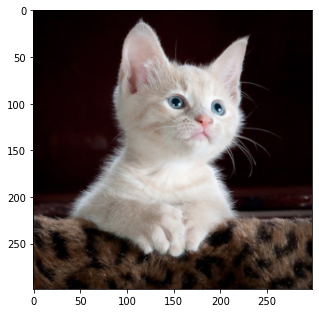

In [6]:
imshow(torchvision.utils.make_grid(images, normalize=True))

## 3. Download and Use Inception v3

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
model = models.googlenet(pretrained=True).to(device)
model._modules.keys()

odict_keys(['conv1', 'maxpool1', 'conv2', 'conv3', 'maxpool2', 'inception3a', 'inception3b', 'maxpool3', 'inception4a', 'inception4b', 'inception4c', 'inception4d', 'inception4e', 'maxpool4', 'inception5a', 'inception5b', 'aux1', 'aux2', 'avgpool', 'dropout', 'fc'])

In [9]:
model.eval()

images = images.to(device)
outputs = model(images)
_, pre = torch.max(outputs.data, 1)

print(pre)

tensor([285], device='cuda:0')


In [10]:
class_idx = json.load(open("./data/imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

In [11]:
idx2label[283]

'Persian_cat'

In [12]:
true_labels = torch.tensor([283])

## 4. Saliency Map

In [13]:
loss = nn.CrossEntropyLoss()

In [14]:
images = images.to(device)
true_labels = true_labels.to(device)

images.requires_grad = True

outputs = model(images)

model.zero_grad()
cost = loss(outputs, true_labels).to(device)
cost.backward()

In [15]:
images.shape

torch.Size([1, 3, 299, 299])

In [16]:
grad_abs = images.grad.abs().detach().clone()
grad_abs = grad_abs.sum(dim=1)

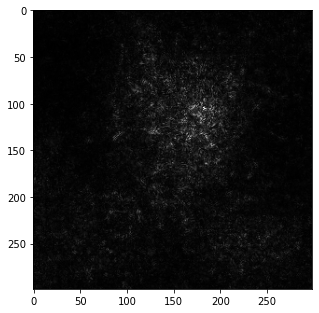

In [17]:
imshow(torchvision.utils.make_grid(grad_abs.cpu(), normalize=True))

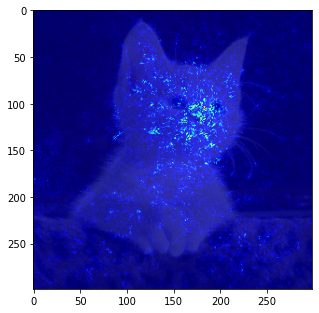

In [18]:
highlight = torchvision.utils.make_grid(grad_abs.cpu(), normalize=True)
imshow(torchvision.utils.make_grid(images.cpu(), normalize=True), highlight=highlight)

## 5. CAM

In [19]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.utils
    
r"""
Implementation of CAM

Arguments:
    model (nn.Module): a model with one GAP(Global Average Pooling) and one FC(Fully-Connected).
    images (torch.tensor): input images of (batch_size, n_channel, height, width).
    last_conv_name (str) : the name of the last convolutional layer of the model.
    fc_name (str) : the name of the last fully-connected layer of the model.
    label (list): According to the label, activated area will be changed.
      * Default : None (It will be automatically determined by predicted label)
      * Warning : It has to be same size as the batch_size of the input images.
    normalize (Bool) : Normalized output will be returned if it is True.
      * Default : True (The output have a value between 0 and 255)
    resize (Bool) : Resized output will be returned.
      * Default : True (The output will be resized as same as the input images)

.. note:: it is modified from "https://github.com/metalbubble/CAM/blob/master/pytorch_CAM.py"

"""

def CAM(model, images, last_conv_name, fc_name, label=None, normalize=True, resize=True) :

    device = next(model.parameters()).device

    size = images.shape[-2:]
    
    # 가장 마지막 Conv Layer의 Output 가져오기
    last_conv_features = []

    def hook_feature(module, input, output):
        last_conv_features.append(output.data)

    # inception5b가 Output을 출력할 때마다 hook_feature을 호출
    model._modules.get(last_conv_name).register_forward_hook(hook_feature)
    
    # FC Layer의 weight을 가져오기
    params = dict(getattr(model, fc_name).named_parameters())
    weight_softmax = params['weight'].data
    
    # eval 모드에서 forward 진행
    model.eval()
    feature = model(images.to(device))

    # 예측값 가져오기
    _, pre = feature.max(dim=1)    
    conv_feature = last_conv_features[0]
    b, nc, h, w = conv_feature.shape

    if label is None :
        label = pre
    
    cam = torch.bmm(weight_softmax[label].reshape(b, 1, nc), conv_feature.reshape((b, nc, h*w)))
    cam = cam.reshape(b, 1, h, w)
    
    # Min-Max Normalization
    if normalize :
        cam = (cam - cam.min()) / (cam.max()- cam.min())

    # Resize
    if resize :
        cam = nn.UpsamplingBilinear2d(size=size)(cam)
    
    return cam[0,:,:], pre

In [20]:
cam, pre = CAM(model, images,
               last_conv_name='inception5b', fc_name='fc', 
               label=None, normalize=True, resize=True)

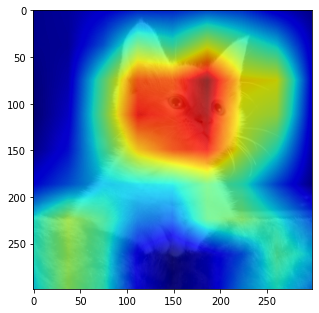

In [21]:
highlight = torchvision.utils.make_grid(cam.cpu(), normalize=False)
imshow(torchvision.utils.make_grid(images.cpu(), normalize=True), highlight=highlight)